EDA of the clean datasets and choice on variables for the recommendation model.

# **1. Import the required libraries.**

In [35]:
'''Necessary libraries.'''
import pandas as pd                 # Pandas for tabular data manipulation.
import json                         # Module for working with JSON.
import ast                          # Module for evaluating Python literal expressions.
import re                           # Module for working with regular expressions.
from textblob import TextBlob       # I import TextBlob from the textblob library.
import nltk                         # Natural Language Toolkit.
import csv                          # I import the CSV module into Python.
import seaborn as sns
import matplotlib.pyplot as plt

'''Enable auto-reload of modules before executing a cell'''
%load_ext autoreload
%autoreload 2

'''Import the warning module and set it to ignore all warnings'''
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **2. Auxiliary Functions**

In [36]:
def check_data_type(df):
    
    '''A dictionary (my_dict) is created with five keys: "field_name", "data_type", "non_null_%", "null_%" and "nulls". 
    These keys will be used to store information about each column of the DataFrame.'''
    
    my_dict = {"field_name" : [], "data_type" : [], "non_null_%" : [], "null_%" : [], "nulls" : []}
    
    
    '''A loop is performed over all the columns of the DataFrame df'''
    for column in df.columns:
        percentage_non_nulls = (df[column].count() / len(df) * 100)     # The percentage of non-null values in the current column is calculated 
        my_dict['field_name'].append(column)                            # The current column is added to the list under the key 'field_name'        
        my_dict['data_type'].append(df[column].apply(type).unique())    # Obtain the unique data type in the current column and add it to the list under the key 'data type'.
        my_dict['non_null_%'].append(round(percentage_non_nulls, 2))    # Add the percentage of non-null values to the list under the key 'non_null_%'.
        my_dict['null_%'].append(round(100 - percentage_non_nulls, 2))  # Add the percentage of null values to the list under the key 'null_%'.
        my_dict['nulls'].append(df[column].isnull().sum())              # Add the number of null values in the current column to the list under the key 'nulls'.
        
    '''The dictionari my_dict is used to create a new DataFrame called df_info.'''
    df_info = pd.DataFrame(my_dict)
        
    '''The function returns the DataFrame df_info containing information about each column,
    incluiding the column name, data type, percentage of non-null values, percentage of null values, and the number of null values.'''
    return df_info

In [37]:
def bigote_max(column):
    '''Quartiles'''
    q1 = column.describe()[4]
    q3 = column.describe()[6]
    
    ''' bigote value'''
    bigote_max = round(q3 + 1.5*(q3 - q1), 2)
    print(f'The upper bigote of the {column.name} variable is located at: $',bigote_max)

    '''Number of outliers'''
    print(f'There are {(column > bigote_max).sum()} outliers in the variable {column.name}') 

# **EDA of the user_reviews dataset.**

In this section, we delve into the Exploratory Data Analysis of the user_reviews dataset, which has already undergone the ETL process.


Reading the dataset  
Data is read from a .csv file and saved into a dataframe.

In [38]:

df_reviews = pd.read_csv('C:\\Users\\migue\\Optimizing Recommender Systems with an Advanced MLOps Pipeline\\Datasets\\clean_dataset\\Australian_user_reviews_clean1.csv', encoding='utf-8')
df_reviews.head()

,user_id,user_url,reviews_item_id,reviews_helpful,reviews_recommend,reviews_date,sentiment_analysis
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,1250,No ratings yet,True,2011-11-05,1
1,js41637,http://steamcommunity.com/id/js41637,251610,15 of 20 people (75%) found this review helpful,True,2014-06-24,1
2,evcentric,http://steamcommunity.com/id/evcentric,248820,No ratings yet,True,NaN,2
3,doctr,http://steamcommunity.com/id/doctr,250320,2 of 2 people (100%) found this review helpful,True,2013-10-14,2
4,maplemage,http://steamcommunity.com/id/maplemage,211420,35 of 43 people (81%) found this review helpful,True,2014-04-15,1


Data types and null counts are reviewed, if any


In [39]:
'''Calculating the number of records'''
print(f'The number of records present is: {df_reviews.shape[0]}')

'''Reviewing data types and checking for null values'''
check_data_type(df_reviews)

The number of records present is: 57367


,field_name,data_type,non_null_%,null_%,nulls
0,user_id,[<class 'str'>],100.00,0.00,0
1,user_url,[<class 'str'>],100.00,0.00,0
2,reviews_item_id,[<class 'int'>],100.00,0.00,0
3,reviews_helpful,[<class 'str'>],100.00,0.00,0
4,reviews_recommend,[<class 'bool'>],100.00,0.00,0
5,reviews_date,"[<class 'str'>, <class 'float'>]",82.97,17.03,9768
6,sentiment_analysis,[<class 'int'>],100.00,0.00,0


We have 57,397 records of user opinions regarding the games they consume.  
Although there are no null values, it's worth noting that during the ETL process, missing data was observed in the 'reviews_date' column, which was filled with 'Invalid Format'.

The 'sentiment_analysis' and 'reviews_recommend' columns are explored

In [40]:
def summary_percentage_quantity(df, column):
    
    '''Count the number of True/False'''
    counts = df[column].value_counts()
    percentages = round(100 * counts / len(df),2)
    '''Create a dataframe with the summary'''
    df_results = pd.DataFrame({
        "Quantity": counts,
        "Percentage": percentages
    })
    return df_results

In [41]:
summary_percentage_quantity(df_reviews, 'sentiment_analysis')


,Quantity,Percentage
sentiment_analysis,,
1,35241,61.43
2,17100,29.81
0,5026,8.76


In [42]:
summary_percentage_quantity(df_reviews, 'reviews_recommend')


,Quantity,Percentage
reviews_recommend,,
True,50751,88.47
False,6616,11.53


In the review records, nearly 62% of the reviews reflect neutral sentiments, almost 30% reflect positive sentiments towards the game, and less than 9% were negative.  However, in 88% of the reviews, the games they consume are recommended.

The following code aims to visualize the quantity of recommendations for different sentiments in the reviews.

In [43]:
'''Group by 'sentiment_analysis' and 'reviews_recommend'''
df_grouped = df_reviews.groupby(['sentiment_analysis', 'reviews_recommend'])
'''The quantity of reviews is counted in each group.'''
quantity_group = df_grouped.size()
'''The percentage is calculated for each group'''
percentage_group = 100 * df_grouped.size() / len(df_reviews)
'''A dataframe is created with the summary'''
sentiment_recommendation = pd.DataFrame({
    "Quantity": quantity_group,
    "Percentage": percentage_group
})
sentiment_recommendation

Quantity  Percentage
sentiment_analysis reviews_recommend                      
0                  False                  1652    2.879704
                   True                   3374    5.881430
1                  False                  4367    7.612390
                   True                  30874   53.818397
2                  False                   597    1.040668
                   True                  16503   28.767410


It can be observed that nearly 54% of the reviews reflecting a neutral sentiment recommend the game. This suggests that a neutral sentiment might be associated with a simple comment lacking many details but still liking the game enough to recommend it. On the other hand, of the comments reflecting a negative sentiment, around 6% still recommend the game, which is somewhat contradictory.

In [44]:
'''Number of users who gave their opinion'''
print(f"Number of unique users who gave their opinion: {len(df_reviews['user_id'].unique())}")
     

Number of unique users who gave their opinion: 25132


A total of 25,132 users gave their opinion on the game they consume, indicating that some users made more than one comment.


Column 'reviews_date'  
The quantity of dates with invalid format or lacking a date in the original dataset is reviewed.

In [45]:
print(f'The number of dates in invalid format is: {len(df_reviews[df_reviews["reviews_date"]=="Invalid format"])}')


The number of dates in invalid format is: 0


There are 9768 records that do not contain the review date.


The following graph shows the distribution of the number of reviews per day, excluding those without a date.

In [46]:
'''Print the first elements of the "reviews_date" column'''
print(df_reviews["reviews_date"].head(-50))


0        2011-11-05
1        2014-06-24
2               NaN
3        2013-10-14
4        2014-04-15
            ...    
57312    2012-10-29
57313    2014-01-09
57314    2015-01-01
57315    2014-10-02
57316    2015-07-04
Name: reviews_date, Length: 57317, dtype: object


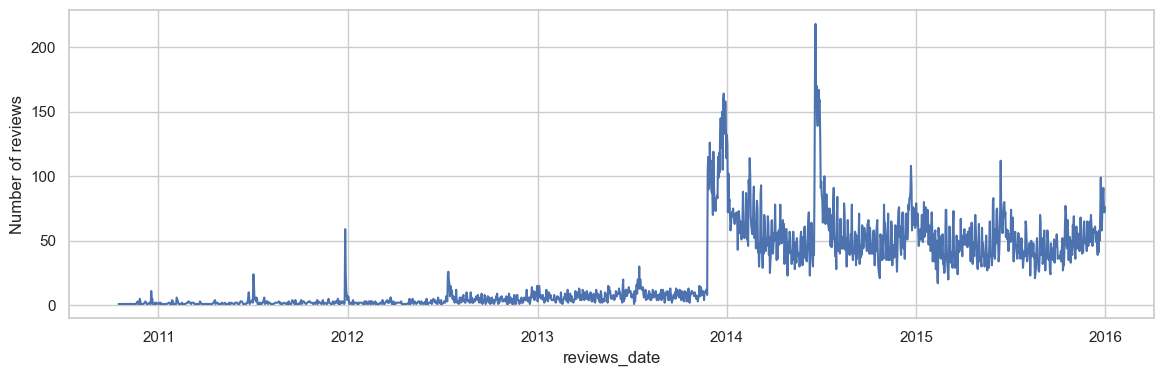

In [47]:
df_reviews["reviews_date"] = pd.to_datetime(df_reviews["reviews_date"], format='%Y-%m-%d', errors='coerce')

'''Create a boolean mask for valid date formats and non-NaN values'''
mask = df_reviews["reviews_date"].notna()

'''Apply the mask to filter the DataFrame'''
df = df_reviews[mask]

'''Convert to datetime'''
df["reviews_date"] = pd.to_datetime(df["reviews_date"])

'''Calculate the number of reviews per date'''
number_reviews = df["reviews_date"].value_counts().reset_index()

'''Rename the columns to match the graph'''
number_reviews.columns = ["reviews_date", "reviews_recommend_count"]

# Graph
plt.figure(figsize=(14, 4))
sns.lineplot(data=number_reviews, x="reviews_date", y="reviews_recommend_count")
plt.ylabel('Number of reviews')
plt.show()


In [48]:

print('Days with peak review quantity')
number_reviews.sort_values(by="reviews_recommend_count", ascending=False)[:5]

Days with peak review quantity


,reviews_date,reviews_recommend_count
0,2014-06-21,218
1,2014-06-20,187
2,2014-06-23,170
3,2014-06-27,167
4,2014-06-22,164


Days with peak review quantity

It can be observed that until around 2014, the number of reviews per day is low, with some occasional peaks, and then the quantity of comments increases considerably, with a maximum peak on 2014-06-21 with 218 comments in a single day.

# **EDA of the steam_games dataset.**

In this section, the Exploratory Data Analysis of the steam_games dataset, which has already undergone the ETL process, is conducted.

Reading the dataset  
Data is read from a .csv file and saved into a dataframe.

In [49]:

df_games = pd.read_csv('C:\\Users\\migue\\Optimizing Recommender Systems with an Advanced MLOps Pipeline\\Datasets\\clean_dataset\\Output_steam_games_clean.csv', encoding='utf-8')
df_games.head()

,genres,price,early_access,id,release_year,publisher,app_name,title,developer
0,Action,4.99,False,761140,2018,Kotoshiro,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro
1,Casual,4.99,False,761140,2018,Kotoshiro,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro
2,Indie,4.99,False,761140,2018,Kotoshiro,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro
3,Simulation,4.99,False,761140,2018,Kotoshiro,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro
4,Strategy,4.99,False,761140,2018,Kotoshiro,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro


The data types and quantity of null values, if any, are reviewed.

In [50]:

'''The number of records is calculated.'''
print(f'The total numbers of records is: {df_games.shape[0]}')
'''Data types and the presence of null values are reviewed'''
check_data_type(df_games)

The total numbers of records is: 71551


,field_name,data_type,non_null_%,null_%,nulls
0,genres,[<class 'str'>],100.00,0.00,0
1,price,[<class 'float'>],100.00,0.00,0
2,early_access,[<class 'bool'>],100.00,0.00,0
3,id,[<class 'int'>],100.00,0.00,0
4,release_year,[<class 'str'>],100.00,0.00,0
5,publisher,"[<class 'str'>, <class 'float'>]",99.93,0.07,47
6,app_name,[<class 'str'>],100.00,0.00,0
7,title,[<class 'str'>],100.00,0.00,0
8,developer,[<class 'str'>],100.00,0.00,0


This dataset has 9 columns and 71,551 records. To recall, it contains information related to each game such as price, release year, application and game name, developer and publisher, as well as genre. It is worth noting that the information is repeated because a game can belong to more than one genre.

Columns 'id', 'app_name', and 'title'
These columns refer to the unique identifier of the game and the names of the application and the game title.  
The latter ones do not have much information to analyze at this moment. With the 'id', the number of games can be calculated.

In [51]:

total_games = len(df_games['id'].unique())
print(f"The total number of registered games is: {total_games}")

The total number of registered games is: 28850


There is a total of 28,850 games on the platform.

Column 'genres'
In the analysis of this column, we can see how the games are distributed, which categories have the most games in the dataframe.

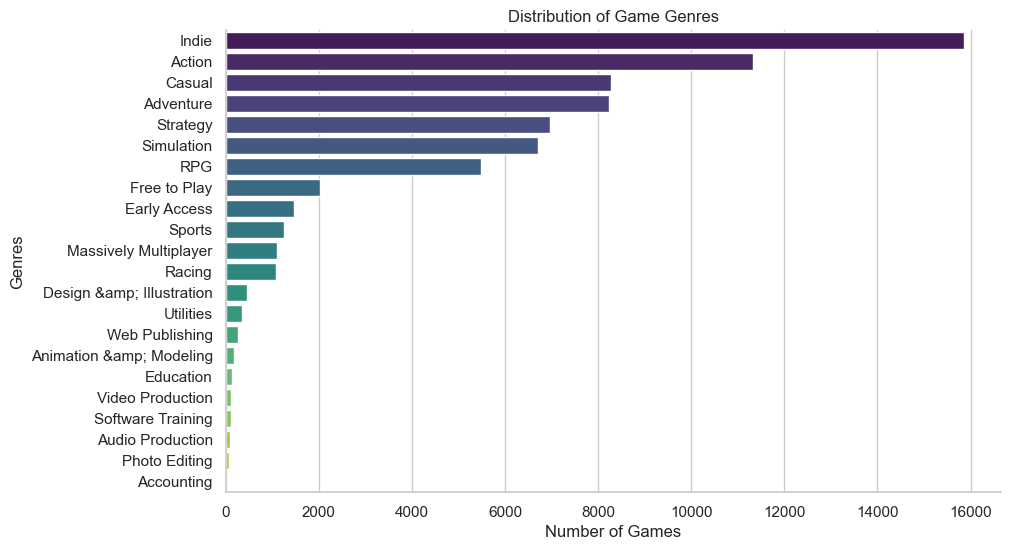

In [52]:
'''Set the seaborn style'''
sns.set(style="whitegrid")

'''Figure size and style.'''
plt.figure(figsize=(10, 6))

'''Create the count plot.'''
ax = sns.countplot(data=df_games, y='genres', order=df_games['genres'].value_counts().index, palette='viridis')

'''Add labels and title'''
plt.title('Distribution of Game Genres')
plt.xlabel('Number of Games')
plt.ylabel('Genres')

'''Adjust layout and display the plot.'''
sns.despine()
plt.show()






We can see the same thing expressed by count and in percentage.

In [53]:

summary_percentage_quantity(df_games, 'genres')

,Quantity,Percentage
genres,,
Indie,15858,22.16
Action,11319,15.82
Casual,8282,11.57
Adventure,8242,11.52
Strategy,6957,9.72
Simulation,6699,9.36
RPG,5479,7.66
Free to Play,2031,2.84
Early Access,1462,2.04


The games are mostly categorized in the genres Indie, Action, Casual, and Adventure.  
It's worth noting that a game can belong to more than one genre.

Column 'release_year'  

In this section, we can observe the number of games released according to the year. We notice that there is a large percentage of games that do not have release date data.

In [54]:
summary_percentage_quantity(df_games, 'release_year')

,Quantity,Percentage
release_year,,
2017,24967,34.89
2016,17667,24.69
2015,12256,17.13
2014,6341,8.86
2013,3016,4.22
2012,2106,2.94
2011,986,1.38
Unavailable data,850,1.19
2010,653,0.91


We can see 679 games released in years prior to 2002, which could be an error since the platform was launched in 2003.  
Additionally, there are 850 games without a specified release date or with incorrect formatting.  
Then, we observe slow and steady growth until 2012, followed by more rapid growth until 2017.  
From there, the platform limited the way of obtaining statistics, resulting in fewer records.




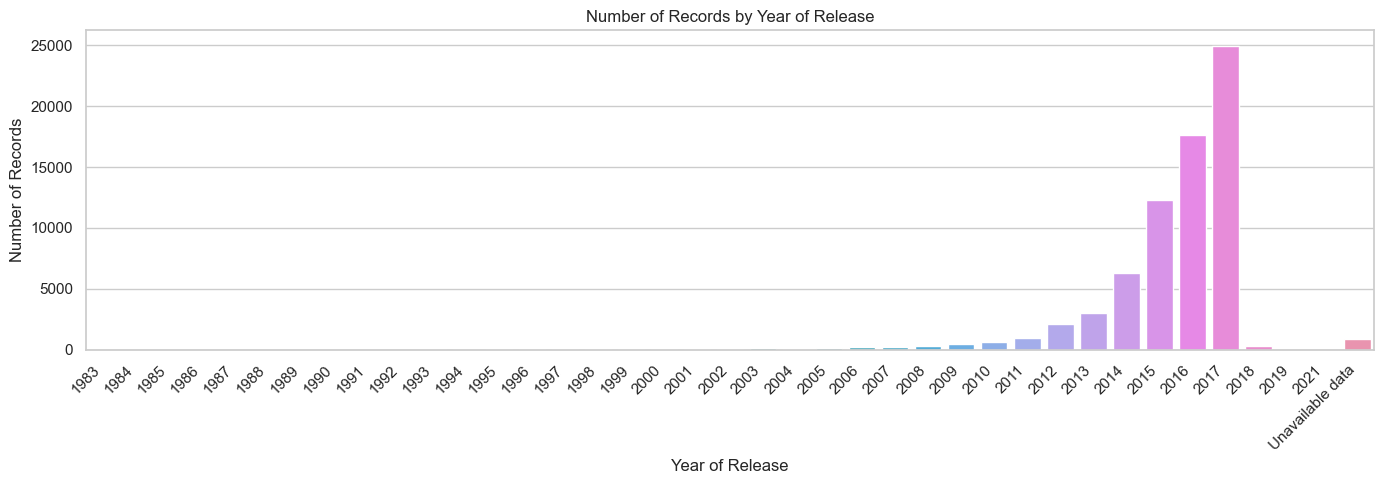

In [55]:
'''Count the frequency of each year'''
years_count = df_games['release_year'].value_counts()

'''Sort the values so that 'Data not available' comes first or last'''
years_count = years_count.reindex(['Unavailable data'] + list(years_count.index))
'''Sort the values by year'''
years_count = years_count.sort_index()

'''Create the bar chart.'''
plt.figure(figsize=(14, 5))
sns.barplot(x=years_count.index, y=years_count.values)
plt.xlabel('Year of Release') ; plt.ylabel('Number of Records') ; plt.title('Number of Records by Year of Release')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [22]:
'''Filter the records with numerical values in the 'release_year' column.'''
numeric_records = df_games[df_games['release_year'].str.isnumeric()]
'''Convert the 'release_year' column to integer values'''
numeric_records['release_year'] = numeric_records['release_year'].astype(int)
'''Filter the records with release years before 2002'''
records_befor_2002 = numeric_records[numeric_records['release_year'] < 2002]

print(f"The number of records before 2002: {len(records_befor_2002)}")
print(f"The number of records with 'Data not available': {df_games[df_games['release_year'] == 'Unavailable data'].shape[0]}")
     

The number of records before 2002: 679
The number of records with 'Data not available': 850


"Publisher" and "Developer" columns

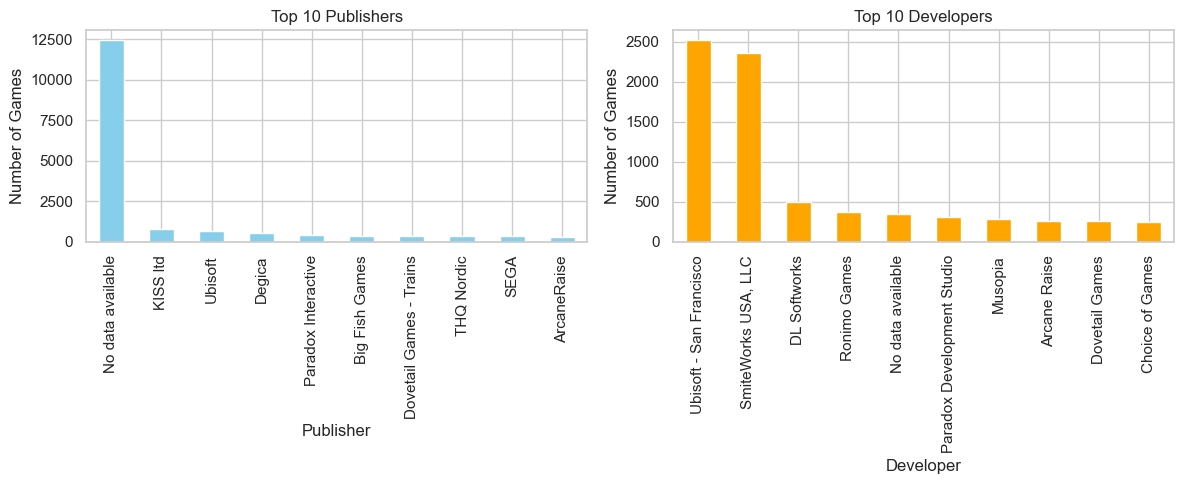

In [56]:
'''Count the number of games per publisher'''
count_publisher = df_games['publisher'].value_counts()

'''Count the number of games per developer'''
count_developer = df_games['developer'].value_counts()

'''Create a figure with two subplots side by side'''
plt.figure(figsize=(12, 5))

'''First subplot for the publishers'''
plt.subplot(1, 2, 1)
count_publisher[:10].plot(kind='bar', color='skyblue')
plt.xlabel('Publisher') ; plt.ylabel('Number of Games') ; plt.title('Top 10 Publishers')

'''Second subplot for the developers'''
plt.subplot(1, 2, 2)
count_developer[:10].plot(kind='bar', color='orange')
plt.xlabel('Developer') ; plt.ylabel('Number of Games') ; plt.title('Top 10 Developers')

'''Show and adjust the spacing between subplots'''
plt.tight_layout()
plt.show()

In the case of game publishers, the majority of them have "Data not available", and in the case of developers, Ubisoft and SmiteWorks are the developers that have developed the most games for the platform.

Column 'price'


In [57]:
df_price1 = df_games['price'].sample(200,random_state=5)


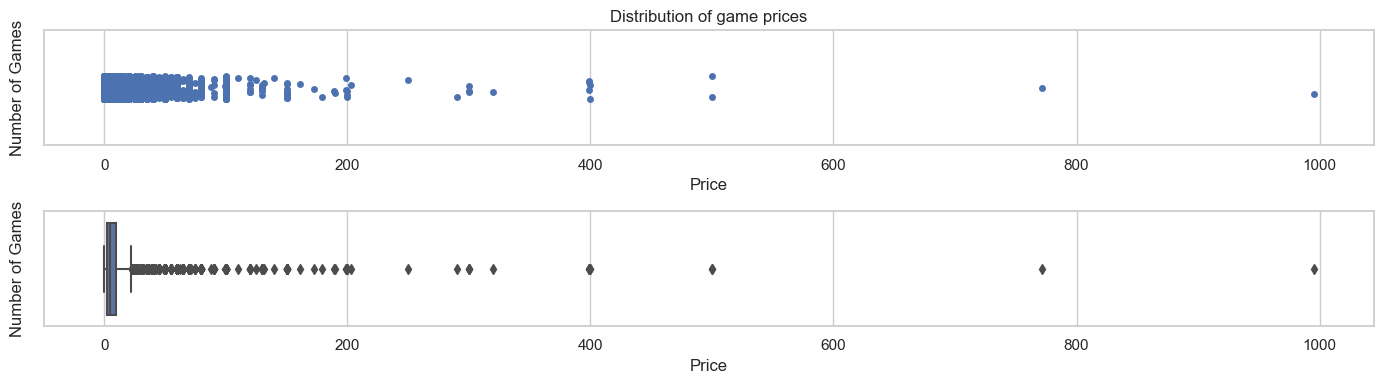

In [58]:
'''Obtain the prices for each game and create a dataframe'''
unique_prices = df_games.groupby('id')['price'].unique().reset_index().explode('price')
df_unique_prices = unique_prices['price']

fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(211)
sns.stripplot(data=unique_prices, x='price', ax=ax1)
ax1.set_xlabel('Price')
ax1.set_ylabel('Number of Games')
ax1.set_title('Distribution of game prices')

ax2 = fig.add_subplot(212, sharex=ax1)
sns.boxplot(data=unique_prices, x='price', ax=ax2)
ax2.set_xlabel('Price')
ax2.set_ylabel('Number of Games')

'''Show and adjust the spacing between subplots'''
plt.tight_layout()
plt.show()


In [59]:
Statistics = df_unique_prices.astype(float).describe()
print(f'The median price of games is: $ {Statistics[5]}')
print(f'The mean price of games is: $ {round(Statistics[1],2)}')
print(f'75% of the games have a price lower than: $ {Statistics[6]}')
bigote_max(pd.DataFrame(df_unique_prices.astype(float))['price'])
     

The median price of games is: $ 4.99
The mean price of games is: $ 8.62
75% of the games have a price lower than: $ 9.99
The upper bigote of the price variable is located at: $ 21.99
There are 1746 outliers in the variable price


It can be seen that almost 50% of the games have prices between 0 and $4.99, and 75% of the games have prices lower than $9.99. There are 1746 values that can be considered outliers, with prices higher than $21.99, but undoubtedly there are some games priced over $250 that may be errors in pricing.

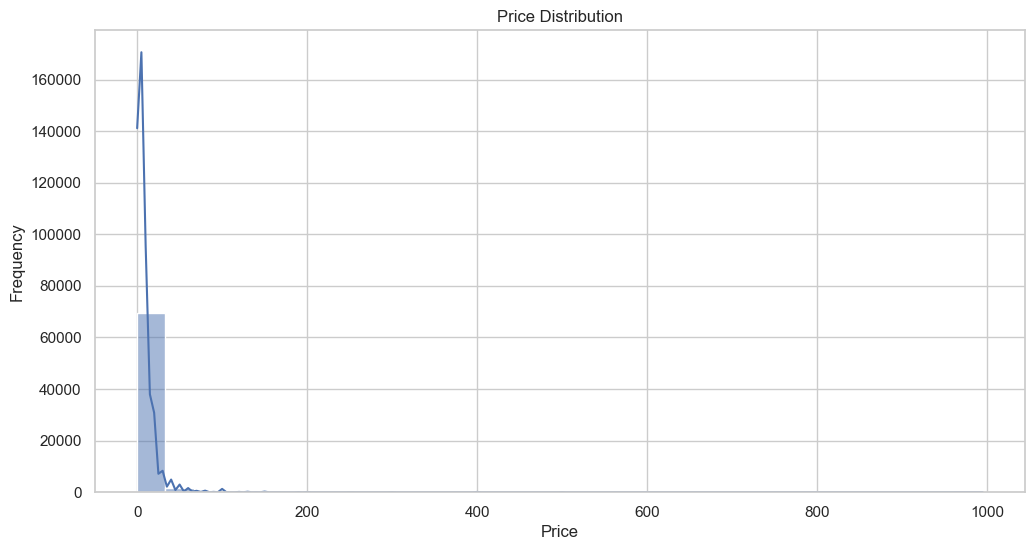

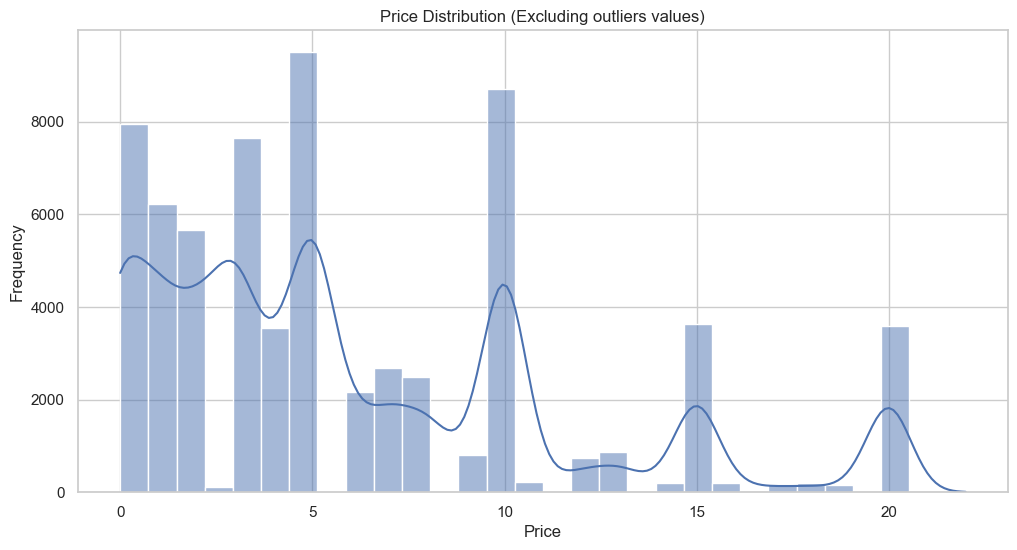

Median price: 4.99
Mean price: 8.444273595058071
Percentage below 10.0: 80.38741596902909%
There are outlier values: 4057


In [60]:

price_median = df_games['price'].median()


mean_price = df_games['price'].mean()

'''Percentage below a specific value (entered by the user)'''
threshold_value = float(input("Ingrese el valor umbral para calcular el porcentaje: "))
percentage_below_threshold = (df_games['price'] < threshold_value).mean() * 100

'''Outliers Values'''
Q1 = df_games['price'].quantile(0.25)
Q3 = df_games['price'].quantile(0.75)
IQR = Q3 - Q1
outlier_values = ((df_games['price'] < (Q1 - 1.5 * IQR)) | (df_games['price'] > (Q3 + 1.5 * IQR)))

'''Number of outlier values'''
number_outlier_values = outlier_values.sum()

'''Price chart'''
plt.figure(figsize=(12, 6))
sns.histplot(df_games['price'], bins=30, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

'''Chart excluding outliers values'''
plt.figure(figsize=(12, 6))
sns.histplot(df_games.loc[~outlier_values, 'price'], bins=30, kde=True)
plt.title('Price Distribution (Excluding outliers values)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

'''Print results'''
print(f"Median price: {price_median}")
print(f"Mean price: {mean_price}")
print(f"Percentage below {threshold_value}: {percentage_below_threshold}%")
print(f"There are outlier values: {number_outlier_values}")

# **EDA of the user_items dataset.**

In this section, we conduct Exploratory Data Analysis of the users_items dataset that has already undergone the ETL process.

**Reading the dataset**  
The data is read from a .csv file and saved into a dataframe.

In [61]:
df_items = pd.read_csv('C:\\Users\\migue\\Optimizing Recommender Systems with an Advanced MLOps Pipeline\\Datasets\\clean_dataset\\Australian_users_items_clean.csv', encoding='utf-8')
df_items.head()

,item_id,item_name,playtime_forever,steam_id,items_count,user_id,user_url
0,10,Counter-Strike,6,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
1,20,Team Fortress Classic,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
2,30,Day of Defeat,7,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
3,40,Deathmatch Classic,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
4,50,Half-Life: Opposing Force,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...


Checking data types and presence of null values.


In [62]:
'''Calculating the number of records.'''
print(f'The number of records present is: {df_items.shape[0]}')

check_data_type(df_items)

The number of records present is: 5094105


,field_name,data_type,non_null_%,null_%,nulls
0,item_id,[<class 'int'>],100.0,0.0,0
1,item_name,[<class 'str'>],100.0,0.0,0
2,playtime_forever,[<class 'int'>],100.0,0.0,0
3,steam_id,[<class 'int'>],100.0,0.0,0
4,items_count,[<class 'int'>],100.0,0.0,0
5,user_id,[<class 'str'>],100.0,0.0,0
6,user_url,[<class 'str'>],100.0,0.0,0


This dataset has 7 columns and 5094105 records. To recall, it contains information related to users and the games they consume such as the accumulated time (in minutes) they have played a game, the quantity of items they consume, as well as the identifiers of the games they consume and of the user itself, and the URL of the user's profile.

**Column 'playtime_forever'**  


This column refer to the accumulated minutes of playtime for a user.

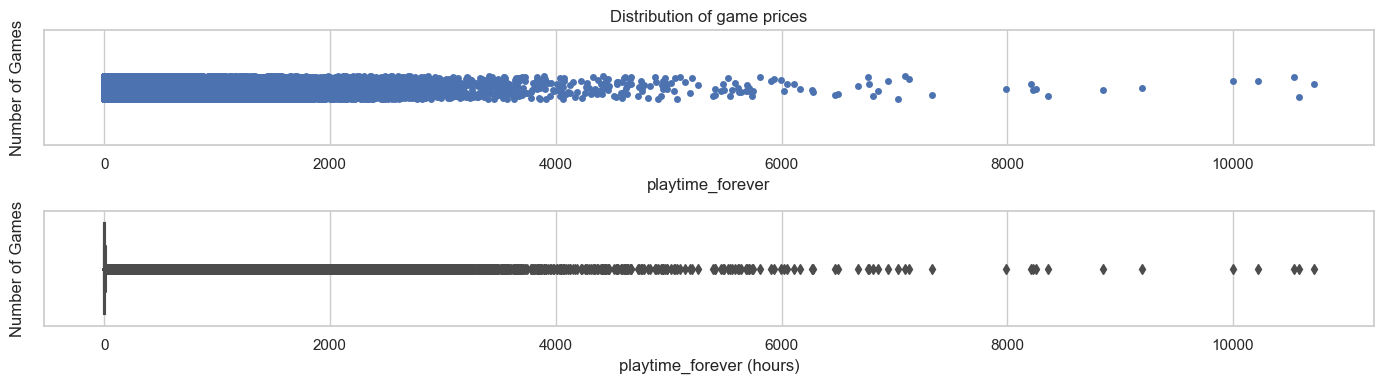

In [63]:
df_items['playtime_hours'] = df_items['playtime_forever'] / 60

fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(211)
sns.stripplot(data=df_items, x='playtime_hours', ax=ax1)
ax1.set_xlabel('playtime_forever') ; ax1.set_ylabel('Number of Games') ; ax1.set_title('Distribution of game prices')

ax2 = fig.add_subplot(212, sharex=ax1)
sns.boxplot(data=df_items, x='playtime_hours', ax=ax2)
ax2.set_xlabel('playtime_forever (hours)') ; ax2.set_ylabel('Number of Games')


plt.tight_layout()
plt.show()
     

In [64]:
statistics = df_items['playtime_hours'].describe()
print(f'The median game time is: {round(statistics[5],2)}')
print(f'The mean game time is: {round(statistics[1],2)}')
print(f'75% of games are timed lower than: {round(statistics[6],2)}')
bigote_max(df_items['playtime_hours'])
     

The median game time is: 0.57
The mean game time is: 16.51
75% of games are timed lower than: 5.92
The upper bigote of the playtime_hours variable is located at: $ 14.79
There are 763606 outliers in the variable playtime_hours


It can be observed that each user spends an average of 0.57 hours playing per game, and 75% of players spent less than 6 hours playing a game. However, there is a significant number of outliers above the 14.79 hours that each user spends playing a game. This could be due to the use of bots that use the same user profile to play simultaneously, which would distort the actual playtimes.

**Columna 'items_count'**  
This column indicates the number of games that users have consumed or purchased at any time.

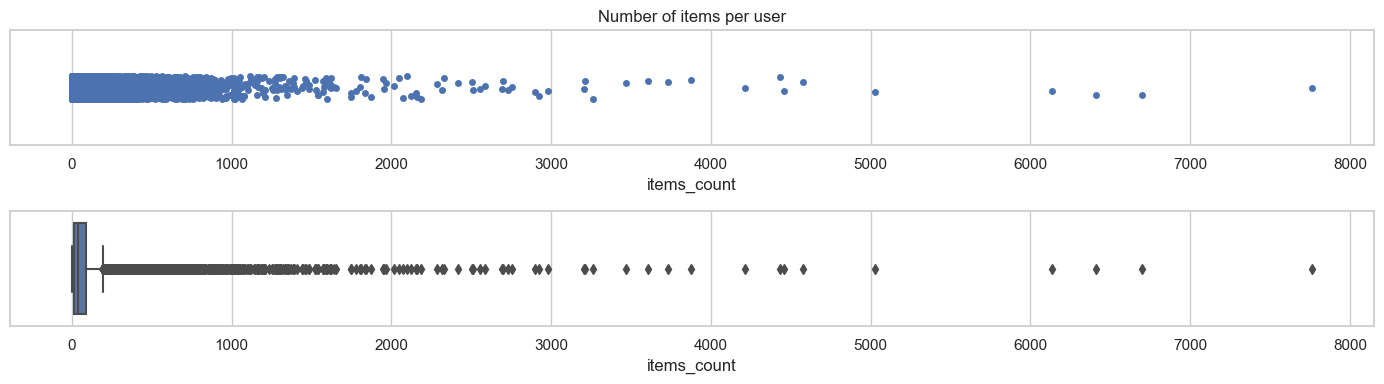

In [65]:

items_count_user = df_items.groupby('user_id')['items_count'].unique().explode()
items_count_user = pd.DataFrame(items_count_user)
items_count_user_o = items_count_user.sort_values('items_count', ascending=False)

fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(211)
sns.stripplot(data=items_count_user_o, x='items_count', ax=ax1)
ax1.set_xlabel('items_count') ; ax1.set_title('Number of items per user')

ax2 = fig.add_subplot(212, sharex=ax1)
sns.boxplot(data=items_count_user_o, x='items_count', ax=ax2)
ax2.set_xlabel('items_count')


plt.tight_layout()
plt.show()

In [66]:
estadisticas = items_count_user['items_count'].astype(float).describe()
print(f'The median quantity of items per user is: {round(estadisticas[5],2)}')
print(f'The average quantity of items per user is: {round(estadisticas[1],2)}')
print(f'75% of users have less than: {round(estadisticas["75%"], 2)} items')
bigote_max(items_count_user.astype(float)['items_count'])

The median quantity of items per user is: 40.0
The average quantity of items per user is: 71.84
75% of users have less than: 87.0 items
The upper bigote of the items_count variable is located at: $ 196.5
There are 4957 outliers in the variable items_count


<Figure size 1400x500 with 0 Axes>

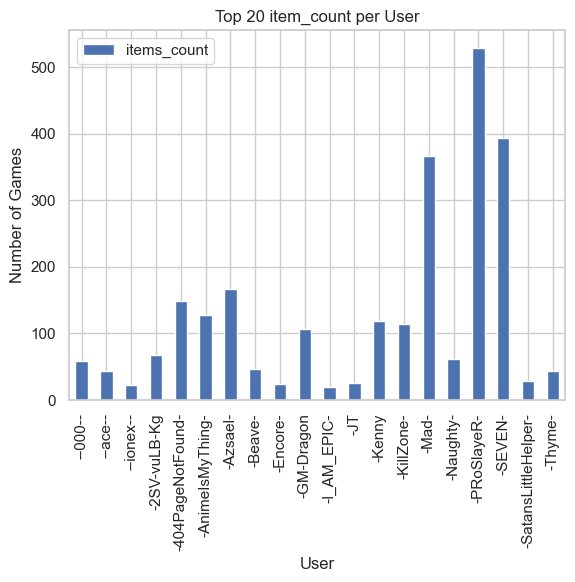

In [67]:

plt.figure(figsize=(14, 5))
items_count_user[:20].plot(kind='bar')
plt.xlabel('User') ; plt.ylabel('Number of Games') ; plt.title('Top 20 item_count per User')
plt.show()
     

It can be seen that the user who has consumed the highest number of games is around 8000, but 75% of users have purchased fewer than 87 items. There are 4957 users who have purchased more than 196 items, which could be considered as outliers.